<a id='top'></a>
# Reproduce Plots in the Final Version of the Paper
This noteboook will load the data files made available with the paper, and generate the plots as they are in the final version of the submission.

Plots available:

1. [Followers](#followers)
1. [Bot score of connections](#botscore)
1. [Exposure to echo chamber](#echo_chamber)
1. [Exposure to low credibity content](#misinformation)
1. [Home timeline drift](#home_timeline)
1. [User timeline drift](#user_timeline)
1. [Algorithmic bias](#bias)

In [65]:
# imports
%load_ext autoreload
%autoreload 2

import os
# import sys
# sys.path.insert(1, './')
import plot_helper as plt_helper
# from collections import OrderedDict
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import dates
# import json
%matplotlib inline


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [66]:
import warnings
import matplotlib.cbook
warnings.filterwarnings("ignore",category=matplotlib.cbook.MatplotlibDeprecationWarning)

In [67]:
plt.rcParams.update({'font.size': 20})

DATA_PATH = "../data/"
OUTPUT_PATH = "./images_out/"

[back to top](#top) <a id='followers'></a>
## Followers           
The evolution of the number of followers.

In [4]:
# load followers data
followers_df = pd.read_csv(os.path.join(DATA_PATH,"followers_data.csv"),index_col=0)
followers_df.index = pd.to_datetime(followers_df.index)
followers_df.head(2)

,bot11,bot14,bot12,bot13,bot10,bot7,bot2,bot5,bot6,bot15,bot1,bot4,bot3,bot8,bot9
date,,,,,,,,,,,,,,,
2019-07-13,1.0,NaN,1.0,3.0,NaN,1.0,NaN,NaN,NaN,1.0,NaN,2.0,1.0,1.0,NaN
2019-07-14,NaN,1.0,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0


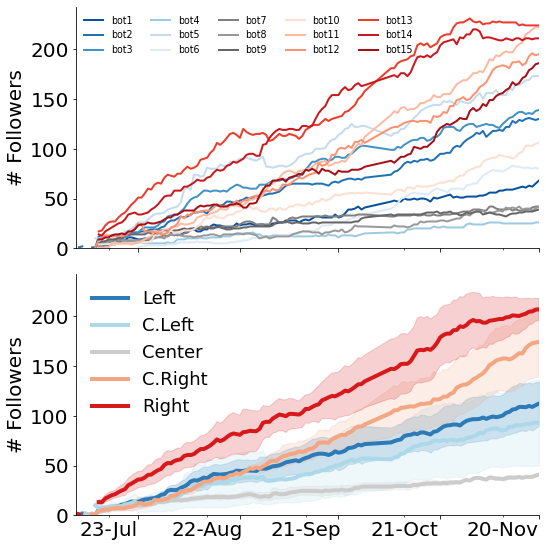

In [5]:
plt_helper.plot_bots_and_summary(
    bots_df=followers_df[followers_df.index<dt(2019,12,2)], 
    y_label="# Followers", 
    bots_legend_loc=None,
    filename=os.path.join(OUTPUT_PATH,"followers.pdf"),
    minor_locator = dates.DayLocator(interval=30),
    sem=True,
#     major_formatter = dates.DateFormatter('%d-%b'),
    figsize=(8,8),
    ncol_main_plot=1,
    leg_size_main_plot=18,
    confidence_interval = 1,
    group_legend=["Left","C.Left", "Center", "C.Right", "Right"]
)

[back to top](#top) 
<a id='botscore'></a>
## Bot Score           
Bot score comparision among friends and followers of our accounts.

In [6]:
bot_score_summary = pd.read_csv(
    os.path.join(DATA_PATH,"bot_score_summary.csv"),
    index_col=[0,1]
)
bot_score_summary

mean       std       sem
relationship index                                     
friend       Center        0.169657  0.249306  0.009116
             Center-left   0.203355  0.254144  0.009362
             Center-right  0.256564  0.262230  0.009271
             Left          0.268681  0.271701  0.009817
             Right         0.315996  0.261187  0.008820
follower     Center        0.505729  0.319875  0.030923
             Center-left   0.463571  0.285241  0.022206
             Center-right  0.436814  0.263265  0.015276
             Left          0.463661  0.265377  0.017059
             Right         0.436640  0.238697  0.011717

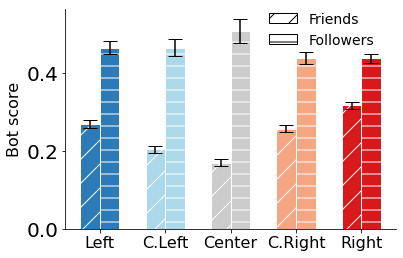

In [7]:
plt_helper.plotTwoBarsPlot(
    bars1 = bot_score_summary.loc[("friend")].loc[plt_helper.INIT_SEED_RENAME.values()]["mean"], 
    bars2 = bot_score_summary.loc[("follower")].loc[plt_helper.INIT_SEED_RENAME.values()]["mean"], 
    yer1 = bot_score_summary.loc[("friend")].loc[plt_helper.INIT_SEED_RENAME.values()]["sem"], 
    yer2 = bot_score_summary.loc[("follower")].loc[plt_helper.INIT_SEED_RENAME.values()]["sem"], 
    colors = [plt_helper.ACCOUNT_COLORS[k] for k in plt_helper.INIT_SEED_RENAME.values()], 
    xticks=['Left', 'C.Left', 'Center', 'C.Right', 'Right'], 
    figname=os.path.join(OUTPUT_PATH,"connections_botscore-combined.pdf"),
    legend_loc=(.6,.8)
);

[back to top](#top) <a id='echo_chamber'></a>
## Echo Chamber           
Estimating exposure to echo chamber via density and clusterig coeficient measurements.

In [8]:
# load dataframe
echo_chamber_df = pd.read_csv(
    os.path.join(DATA_PATH, "echo_chamber_data.csv"),
    index_col=[0,1]
)
echo_chamber_df.head()

Left  Center-left    Center  Center-right     Right
avg_clus      mean  0.563835     0.548106  0.563015      0.573352  0.577113
              sem   0.020577     0.041300  0.008027      0.008723  0.013674
avg_clus_rand mean  0.212491     0.196984  0.178126      0.278441  0.281790
              sem   0.010995     0.024377  0.002278      0.012198  0.011814
density       mean  0.084752     0.073993  0.050825      0.141056  0.149241

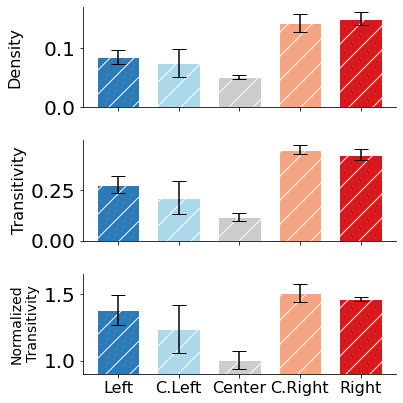

In [9]:
colors = [plt_helper.ACCOUNT_COLORS[k] for k in echo_chamber_df.columns]
fig, axs = plt.subplots(3,1, sharex=True,figsize=(6,6))

value_to_plot = "density"
plt_helper.plotTwoBarsPlot(
    bars1 = echo_chamber_df.loc[(value_to_plot,"mean")], 
    yer1 = echo_chamber_df.loc[(value_to_plot,"sem")], 
    colors = colors,
    xticks=['Left', 'C.Left', 'Center', 'C.Right', 'Right'], 
    saveFig=False,
#     figname=os.path.join(OUTPUT_PATH,"echo_chamber-density.pdf"),
    barWidth=0.7,
    ax=axs[0],
    ylabel="Density\n"
)

value_to_plot = "trans"
plt_helper.plotTwoBarsPlot(
    bars1 = echo_chamber_df.loc[(value_to_plot,"mean")], 
    yer1 = echo_chamber_df.loc[(value_to_plot,"sem")], 
    colors = colors,
    xticks=['Left', 'C.Left', 'Center', 'C.Right', 'Right'], 
    saveFig=False,
#   figname=os.path.join(OUTPUT_PATH,"echo_chamber-transitivity.pdf"),
    barWidth=0.7,
    ax=axs[1],
    ylabel="Transitivity",
)

value_to_plot = "trans_rand_norm"
plt_helper.plotTwoBarsPlot(
    bars1 = echo_chamber_df.loc[(value_to_plot,"mean")], 
    yer1 = echo_chamber_df.loc[(value_to_plot,"sem")], 
    colors = colors,
    xticks=['Left', 'C.Left', 'Center', 'C.Right', 'Right'], 
    saveFig=False,
#   figname=os.path.join(OUTPUT_PATH,"echo_chamber-normalized_transitivity.pdf"),
    barWidth=0.7,
    ax=axs[2],
    ylabel="Normalized\nTransitivity",
    ylabel_size=14,
    ylim=(.9)
)

plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_PATH,"echo_chamber.pdf"))

[back to top](#top) <a id='misinformation'></a>
## Low Credibility           
Measuring the exposure to misinformation using as proxy the exposure to URL domains of low credibility websites.

In [9]:
low_cred_summary = pd.read_csv(
    os.path.join(DATA_PATH,"low_credibility_summary_data.csv"),
    index_col=0, 
    header=[0, 1, 2], 
    skipinitialspace=True
)
low_cred_summary

low_cred_score_old                                             \
                            sum                             mean             
                            sum        mean        sem       sum      mean   
seed                                                                         
Center                    128.0   42.666667  18.800118  0.026115  0.008705   
Center-left               162.0   54.000000  43.139309  0.029846  0.009949   
Center-right              987.0  329.000000  78.117433  0.292726  0.097575   
Left                      114.0   38.000000  24.542480  0.029712  0.009904   
Right                    1129.0  376.333333  66.237787  0.434573  0.144858   

                                                        new_low_cred_score  \
                        count                                          sum   
                   sem    sum         mean          sem                sum   
seed                                                                         
Center        0.003626  13716  4572.000000  1036.289696              138.0   
Center-left   0.007425  13625  4541.666667   813.457094              182.0   
Center-right  0.006896  10266  3422.000000   924.730772             1081.0   
Left          0.008004  17461  5820.333333  1245.954297              130.0   
Right         0.004100   7867  2622.333333   511.244995             1224.0   

              ...              low_cred_score                         \
              ...        count            sum                          
              ...          sem            sum        mean        sem   
seed          ...                                                      
Center        ...  1043.039948          128.0   42.666667  18.800118   
Center-left   ...   979.771629          162.0   54.000000  43.139309   
Center-right  ...  1020.018028          987.0  329.000000  78.117433   
Left          ...  2520.156895          114.0   38.000000  24.542480   
Right         ...   507.301795         1129.0  376.333333  66.237787   

                                                                             
                  mean                      count                            
                   sum      mean       sem    sum         mean          sem  
seed                                                                         
Center        0.026115  0.008705  0.003626  13716  4572.000000  1036.289696  
Center-left   0.029846  0.009949  0.007425  13625  4541.666667   813.457094  
Center-right  0.292767  0.097589  0.006890  10265  3421.666667   924.946905  
Left          0.029713  0.009904  0.008003  17459  5819.666667  1245.536341  
Right         0.434614  0.144871  0.004093   7866  2622.000000   510.955967  

[5 rows x 27 columns]

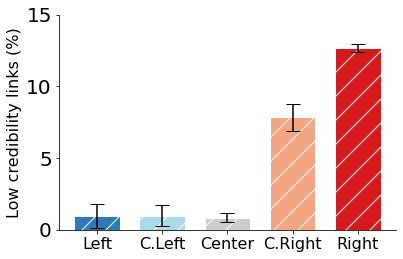

In [14]:
ax = plt_helper.plotTwoBarsPlot(
    bars1 = low_cred_summary.loc[plt_helper.INIT_SEED_RENAME.values(),"new_low_cred_score"]["mean"]["mean"]*100, 
    yer1 = low_cred_summary.loc[plt_helper.INIT_SEED_RENAME.values(),"new_low_cred_score"]["mean"]["sem"]*100, 
    colors = [plt_helper.ACCOUNT_COLORS[k] for k in plt_helper.INIT_SEED_RENAME.values()], 
    xticks=['Left', 'C.Left', 'Center', 'C.Right', 'Right'], 
    figname=os.path.join(OUTPUT_PATH,"low_credibility_no_breitbart-low_cred_urls_mean.pdf"),
    barWidth=0.7,
    ylabel="Low credibility links (%)",
    ylim=(0,15)
);

[back to top](#top) <a id='home_timeline'></a>
## Home Timeline Drift           
The political alignment score over time based on the content (URL and hashtag) **presented to** our accounts home timeline.

In [68]:
summary_results = []

In [69]:
def get_central_score(medium):
    return plt_helper.USATODAY_HASHTAG_SCORE if medium == "hashtag" else plt_helper.SEED_URL_SCORE.get("USATODAY")

In [70]:
loc= "home"

### Based on URL scores

In [71]:
medium = "url"
home_tl_df = plt_helper.load_data(
    medium, 
    loc, 
    center_score= get_central_score(medium), 
    basepath= os.path.join(DATA_PATH,"time_series/")
)
home_tl_df.head(2)

,bot11,bot11_var,bot11_count,bot11_sem,bot10,bot10_var,bot10_count,bot10_sem,bot13,bot13_var,...,bot4_count,bot4_sem,bot7,bot7_var,bot7_count,bot7_sem,bot6,bot6_var,bot6_count,bot6_sem
date,,,,,,,,,,,,,,,,,,,,,
2019-07-10,0.027300,0.016830,3.0,0.07490,-0.092770,0.037552,10.0,0.061280,0.303400,NaN,...,3.0,0.105983,0.065425,0.024943,2.0,0.111675,-0.115150,0.036185,11.0,0.057355
2019-07-11,-0.030775,0.008049,8.0,0.03172,-0.053227,0.000132,51.0,0.001611,0.391152,0.05341,...,9.0,0.038037,0.013579,0.004645,12.0,0.019674,-0.100128,0.015045,38.0,0.019897


In [72]:
summary_results.append(("{}-{}".format(loc,medium),home_tl_df))

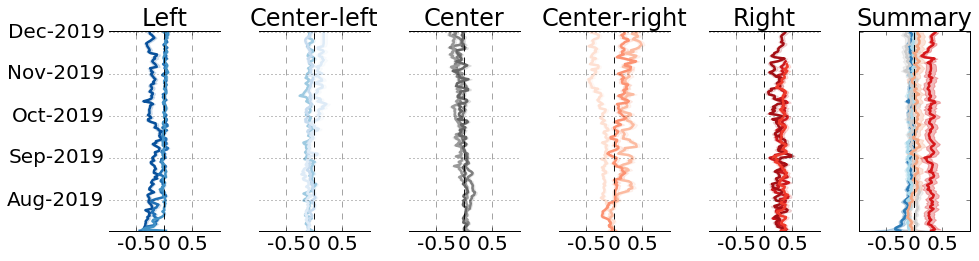

In [73]:
plt_helper.plot_vertical_scores(
    home_tl_df, 
    summary_xlim=[-1,1], 
    xlabel="",
    filename=os.path.join(OUTPUT_PATH,"timeline_{}_{}.pdf".format(loc,medium))
);

### Based on HASHTAG scores

In [74]:
medium = "hashtag"
home_tl_df = plt_helper.load_data(
    medium, 
    loc, 
    center_score=get_central_score(medium), 
    basepath= os.path.join(DATA_PATH,"time_series/")
)
home_tl_df.head(2)

,bot11,bot11_var,bot11_count,bot11_sem,bot10,bot10_var,bot10_count,bot10_sem,bot13,bot13_var,...,bot4_count,bot4_sem,bot7,bot7_var,bot7_count,bot7_sem,bot6,bot6_var,bot6_count,bot6_sem
date,,,,,,,,,,,,,,,,,,,,,
2019-07-10,-0.089336,0.002496,2.0,0.035328,NaN,NaN,NaN,NaN,0.895856,NaN,...,NaN,NaN,0.106678,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2019-07-11,0.020256,0.019577,4.0,0.069959,0.004109,0.029351,2.0,0.121142,0.663100,0.093922,...,NaN,NaN,0.154390,0.009247,5.0,0.043005,0.111181,0.002796,3.0,0.03053


In [75]:
summary_results.append(("{}-{}".format(loc,medium),home_tl_df))

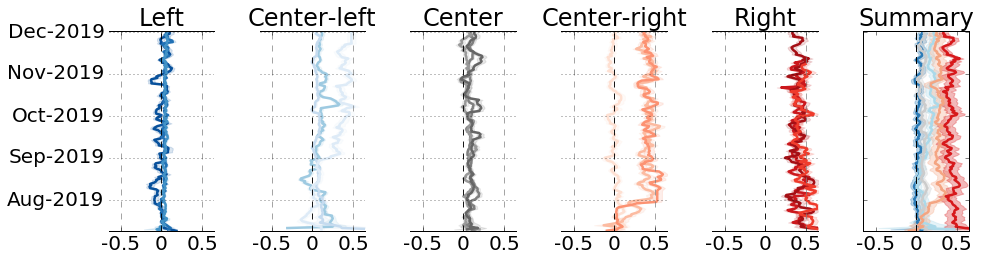

In [76]:
plt_helper.plot_vertical_scores(
    home_tl_df, 
    summary_xlim=[-.65,.65], 
    xlabel="M2 - URL (User timeline) score for the bots",
    filename=os.path.join(OUTPUT_PATH,"timeline_{}_{}.pdf".format(loc,medium))
);

[back to top](#top) <a id='user_timeline'></a>
## User Timeline Drift           
The political alignment score over time based of the content (URL and hashtag) **generated by** our accounts.

In [77]:
loc= "usr"

### Based on URL scores

In [78]:
medium = "url"
user_tl_df = plt_helper.load_data(
    medium, 
    loc, 
    center_score= get_central_score(medium), 
    basepath= os.path.join(DATA_PATH,"time_series/")
)
user_tl_df.head(2)

,bot11,bot11_var,bot11_count,bot11_sem,bot10,bot10_var,bot10_count,bot10_sem,bot13,bot13_var,...,bot4_count,bot4_sem,bot7,bot7_var,bot7_count,bot7_sem,bot6,bot6_var,bot6_count,bot6_sem
date,,,,,,,,,,,,,,,,,,,,,
2019-07-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,0.056917,0.039494,3.0,0.114738
2019-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.069167,NaN,...,2.0,0.075775,0.0,NaN,1.0,NaN,0.023140,0.028308,5.0,0.075243


In [79]:
summary_results.append(("{}-{}".format(loc,medium),user_tl_df))

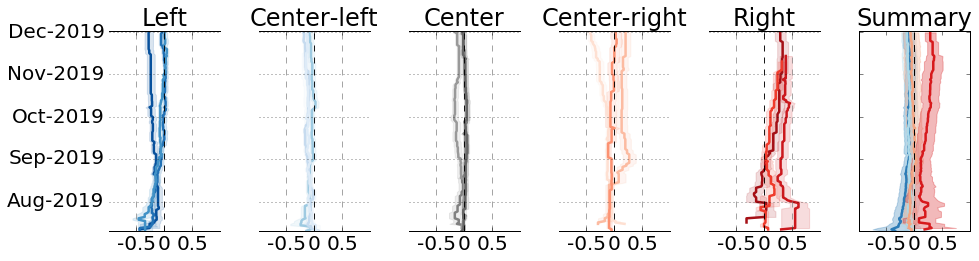

In [80]:
plt_helper.plot_vertical_scores(
    user_tl_df, 
    summary_xlim=[-1,1], 
    xlabel="",
    filename=os.path.join(OUTPUT_PATH,"timeline_{}_{}.pdf".format(loc,medium))
);

### Based on HASHTAG scores

In [81]:
medium = "hashtag"
user_tl_df = plt_helper.load_data(
    medium, 
    loc, 
    center_score= get_central_score(medium), 
    basepath= os.path.join(DATA_PATH,"time_series/")
)
user_tl_df.head(2)

,bot11,bot11_var,bot11_count,bot11_sem,bot10,bot10_var,bot10_count,bot10_sem,bot13,bot13_var,...,bot4_count,bot4_sem,bot7,bot7_var,bot7_count,bot7_sem,bot6,bot6_var,bot6_count,bot6_sem
date,,,,,,,,,,,,,,,,,,,,,
2019-07-11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.139212,NaN,1.0,NaN
2019-07-12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.314225,NaN,1.0,NaN,0.139212,NaN,1.0,NaN


In [82]:
summary_results.append(("{}-{}".format(loc,medium),user_tl_df))

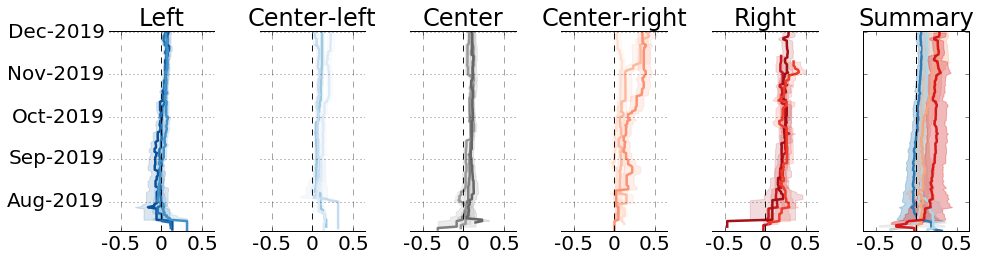

In [83]:
plt_helper.plot_vertical_scores(
    user_tl_df, 
    summary_xlim=[-.65,.65], 
    xlabel="",
    filename=os.path.join(OUTPUT_PATH,"timeline_{}_{}.pdf".format(loc,medium))
);

[back to top](#top) <a id='bias'></a>
## Algorithimic Bias
Checking whether or not the platform influence some sort of suppression or propaganda over the content generated by their users. We measure the difference between what the friends of one account generate (i.e., potential input - friends user timeline) and one's home timeline (i.e., real input).

In [84]:
loc= "friend_usr"

### Based on URL scores

In [85]:
medium = "url"
bias_tl_df = plt_helper.load_data_bias(
    medium, 
    basepath= os.path.join(DATA_PATH,"time_series/")
)
bias_tl_df.head(2)

,bot11,bot11_sem,bot11_var,bot11_count,bot10,bot10_sem,bot10_var,bot10_count,bot13,bot13_sem,...,bot4_var,bot4_count,bot7,bot7_sem,bot7_var,bot7_count,bot6,bot6_sem,bot6_var,bot6_count
date,,,,,,,,,,,,,,,,,,,,,
2019-07-13,NaN,NaN,NaN,NaN,-0.075076,0.005661,0.000477,51.0,-0.059667,0.131892,...,NaN,NaN,-0.080919,0.048548,0.006678,51.0,-0.017608,0.057267,0.012164,51.0
2019-07-14,NaN,NaN,NaN,NaN,-0.075076,0.005661,0.000477,51.0,0.100997,0.054020,...,NaN,51.0,0.004037,0.020983,0.012409,51.0,0.078756,0.031990,0.034447,51.0


In [86]:
summary_results.append(("{}-{}".format(loc,medium),bias_tl_df))

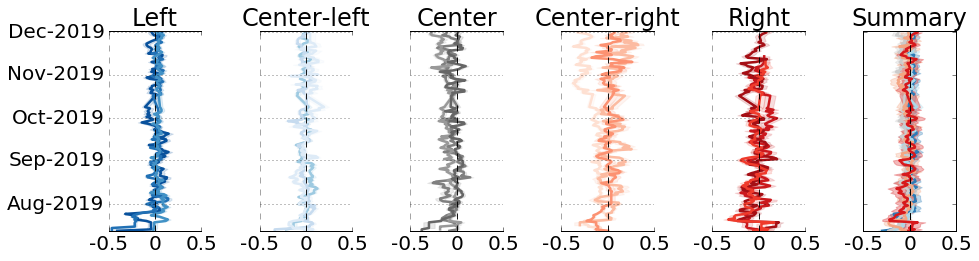

In [87]:
plt_helper.plot_vertical_scores(
    bias_tl_df, 
    summary_xlim=[-.5,.5], 
    xlabel="",
    filename=os.path.join(OUTPUT_PATH,"{}_bias.pdf".format(medium)),
);

### Based on HASHTAG scores

In [88]:
medium = "hashtag"
bias_tl_df = plt_helper.load_data_bias(
    medium, 
    basepath= os.path.join(DATA_PATH,"time_series/")
)
bias_tl_df.head(2)

,bot11,bot11_sem,bot11_var,bot11_count,bot10,bot10_sem,bot10_var,bot10_count,bot13,bot13_sem,...,bot4_var,bot4_count,bot7,bot7_sem,bot7_var,bot7_count,bot6,bot6_sem,bot6_var,bot6_count
date,,,,,,,,,,,,,,,,,,,,,
2019-07-13,NaN,NaN,NaN,NaN,0.036736,0.077055,0.015833,8.0,-0.294449,0.298018,...,NaN,NaN,-0.03703,0.084888,0.017803,14.0,NaN,NaN,NaN,NaN
2019-07-14,NaN,NaN,NaN,NaN,0.036736,0.077055,0.015833,8.0,0.092784,0.057411,...,NaN,7.0,-0.03703,0.084888,0.017803,14.0,NaN,NaN,NaN,NaN


In [89]:
summary_results.append(("{}-{}".format(loc,medium),bias_tl_df))

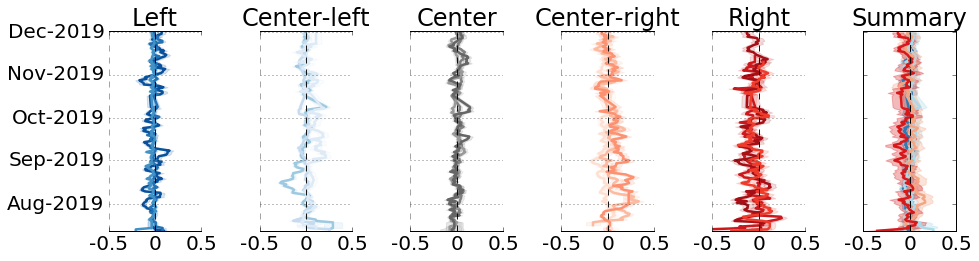

In [90]:
ax = plt_helper.plot_vertical_scores(
    bias_tl_df, 
    summary_xlim=[-.5,.5], 
    xlabel="",
    filename=os.path.join(OUTPUT_PATH,"{}_bias.pdf".format(medium)),
);

[back to top](#top) <a id='summary'></a>
## Drifter Summary
This plot shows the summary of the home timeline, friend's timeline, and algorithimc bias.

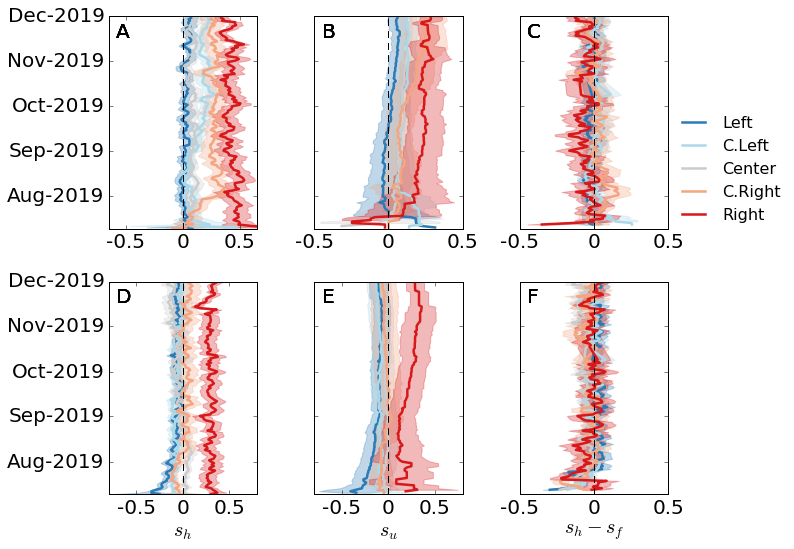

In [91]:
axs = plt_helper.plot_vertical_scores_summary(
    summary_results[1][1], # home timeline
    summary_results[3][1], # friends user timeline
    summary_results[5][1], # algorithmic bias
    summary_results[0][1], # home timeline
    summary_results[2][1], # friends user timeline
    summary_results[4][1], # algorithmic bias
    figsize=(10,8),
    home_tl_xlim=.65, friends_xlim=.5, bias_xlim=.5,
    home_tl_xlim2=.8, friends_xlim2=.8, bias_xlim2=.5,
    filename=os.path.join(OUTPUT_PATH,"drifter_summary_{}.pdf".format("all")),
    
)
